### Be sure to run the ODMX_build_example.ipynb before running this Notebook!

In [1]:
import re
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

To query the ODMX API you can either use your terminal and submit 
curl requests like this:

`curl  localhost:8000/api/odmx/v3/sampling_features | python -m json.tool`

Or within this notebook you can use pythons requests library. 
<br>In order to use the requests library we need to define some boilerplate functions to submit requests to the API.

### API Class Definitions

In [2]:
class ApiException(Exception):
    """
    Exception for SSI API Call. This is thrown when the response is not 200.
    """

    def __init__(self, request, msg=None):
        super(ApiException, self).__init__(msg)
        self.request = request
        self.status_code = request.status_code
        self.msg = msg

    def __str__(self):
        if self.msg is not None:
            return f"{self.request.status_code}: {self.msg}\nResponse Text: {self.request.text}"
        return repr(self.request)


class ApiClient():
    """
    Class for simplifying SSI API REST Calls.
    """

    def __init__(self, token=None, base_url=None):
        self.token = token
        self.base_url = base_url

    def _check_status_error(self, r, call):
        """
        Check for status errors.
        """

        if r.status_code == 404:
            raise ApiException(
                request=r,
                msg=f"Call \"{call}\" was not found."
            )
        elif r.status_code >= 500:
            raise ApiException(
                request=r,
                msg=f"Server returned error code {r.status_code}."
            )
        elif r.status_code != 200:
            try:
                msg = r.json()
            except ValueError:
                msg = r.text
            raise ApiException(
                request=r,
                msg=msg
            )

    def call(self, endpoint: str, params: dict = None, url: str = None):
        """
        Perform an SSI API call.
        """

        if params is None:
            params = {}
        if not isinstance(params, dict):
            raise TypeError("Parameters must be a dictionary.")
        if not isinstance(endpoint, str):
            raise TypeError("Endpoint must be a string.")

        headers = {
            "X-Paf-token": self.token
        }

        if url is None:
            r = requests.get(
                '/'.join([self.base_url, endpoint]), headers=headers, params=params)
        else:
            r = requests.get(url, headers=headers)
        self._check_status_error(r, endpoint)
        return r.json()

#### Instantiate API

In [ ]:
# Because we are querying agains a locally deployed version of the API we don't
# need to define any tokens

# Define the API endpoint URL - this is where we'll be sending the requests
base_url= "http://127.0.0.1:8000/api/odmx/v3"

# Now we can create our api connection using the api_client
api = ApiClient(base_url=base_url)

#### Utility Functions

In [4]:
# These functions help to wrap API requests and format the returned jsons as 
# pandas dataframes in order to expediate data exploration and analysis

# Cache for units and variables DataFrames, this will prevent us from repeatedly pulling tables
_cache = {}

def table_to_df(table_name, display_head=False):
    """
    Parse json outputs from the API into a pandas dataframe.
    @param table_name The ODMX table to pull from the API
    @param display_head Display the head of the parsed dataframe, default False
    @return A pandas dataframe of the ODMX table
    """
    # Check if the table is already in the cache
    if table_name in _cache:
        table_df = _cache[table_name]
    else:
        table_json = api.call(str(table_name))
        table_df = pd.DataFrame(table_json)
        # Store in cache
        _cache[table_name] = table_df

    if display_head:
        display(table_df.head())
    return table_df

def lookup_unit(units_id):
    """
    Lookup unit term based on a passed units_id
    @param units_id The units_id to lookup a term for
    return unit The units term
    """
    units = table_to_df("cv_units")
    unit = units.loc[units['units_id'] == units_id, 'term'].values
    if len(unit) == 0:
        raise ValueError(f"No unit found with units_id={units_id}")
    return unit[0]

def lookup_variable(variable_id):
    """
    Lookup variable term based on a passed variable_id
    @param variable_id The variable_id to lookup a term for
    return variable The variable term
    """
    variables = table_to_df("variables")
    variable = variables.loc[variables['variable_id'] == variable_id, 'variable_term'].values
    if len(variable) == 0:
        raise ValueError(f"No variable found with variable_id={variable_id}")
    return variable[0]

def datastream_to_df(datastream_number, display_head=False):
    """
    Pull timeseries datastream data formatted as a pandas dataframe
    @param datastream_number The datastream number to pull from the API
    @param display_head Display the head of the parsed dataframe, default False
    @return df The timeseries datastream data formatted as a pandas dataframe
    """
    # Get datastream details
    datastream = api.call(f"sampling_feature_timeseries_datastreams/{datastream_number}")
    # Get the variable term so that we can name our dataframe's columns
    variable_term = lookup_variable(datastream['variable_id'])
    df = table_to_df(f"datastream_data/{datastream_number}")
    # The standard datastream_data return is the following
        # Timestamp in UTC
        # The datavalue - we will use the variable_term as this colum header
        # The qa/qc flag
    df.columns = ['timestamp', variable_term, 'qa/qc']
    # Format timestamp as a datetime object
    df.timestamp = pd.to_datetime(df.timestamp)

    # Get the unit term
    unit_term = lookup_unit(datastream['units_id'])
    print(f"Unit for {variable_term} is {unit_term}")

    if display_head:
        display(df.head())
    return df

#### Query the Database

In [5]:
# Let's pull down a dataframe of the sampling features
sampling_features_df = table_to_df("sampling_features", display_head=True)

,sampling_feature_uuid,sampling_feature_type_cv,sampling_feature_code,sampling_feature_id,sampling_feature_name,sampling_feature_description,sampling_feature_geotype_cv,feature_geometry,feature_geometry_wkt,elevation_m,elevation_datum_cv,latitude,longitude,epsg
0,0d855703-d9a5-45c8-8e30-4d6a604aca12,streamGage,NWIS-385106106571000,1,nwis_slate_river,NWIS Water Quality Monitoring Station. See: ht...,point,0101000000EC0F392204BD5AC03AF1EE2B036D4340,POINT(-106.9533773 38.85165929),2691.86,NAVD88,38.851659,-106.953377,None
1,8b5de311-e95b-4a73-b432-10274d750113,streamGage,NWIS-09111250,3,nwis_coal_creek,NWIS Water Quality Monitoring Station. See: ht...,point,0101000000C9B5FC1B0FBF5AC0696CF1218F6F4340,POINT(-106.9852972 38.87155556),2713.64,NAVD88,38.871556,-106.985297,None
2,9d50e7c9-1726-4125-b7df-0f6621833088,streamGage,NWIS-09110990,5,nwis_elk_creek,NWIS Water Quality Monitoring Station. See: ht...,point,0101000000700DC74ED3C35AC0280F0BB5A66D4340,POINT(-107.0597722 38.85665),2916.89,NAVD88,38.856650,-107.059772,None
3,dc6b5fc5-38c8-4eca-9b12-3c7e537fee62,site,NRCS-680,7,snotel_park_cone,NRCS SNOTEL station. See: https://wcc.sc.egov....,point,0101000000E09C11A5BDA55AC0295C8FC2F5684340,POINT(-106.5897 38.82),2923.57,NAVD88,38.820000,-106.589700,None
4,4b96150b-dee1-4c75-872e-637b5a327af4,site,NRCS-669,9,snotel_north_lost_trail,NRCS SNOTEL station. See: https://wcc.sc.egov....,point,01010000003E7958A835C95AC0A7E8482EFF894340,POINT(-107.1439 39.0781),2798.50,NAVD88,39.078100,-107.143900,None


In [6]:
# Sampling features are the backbone of ODMX and give us information about
# where samples were taken and the heirarchy of their relationships
sampling_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272 entries, 0 to 271
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   sampling_feature_uuid         272 non-null    object 
 1   sampling_feature_type_cv      272 non-null    object 
 2   sampling_feature_code         272 non-null    object 
 3   sampling_feature_id           272 non-null    int64  
 4   sampling_feature_name         272 non-null    object 
 5   sampling_feature_description  272 non-null    object 
 6   sampling_feature_geotype_cv   272 non-null    object 
 7   feature_geometry              272 non-null    object 
 8   feature_geometry_wkt          272 non-null    object 
 9   elevation_m                   272 non-null    float64
 10  elevation_datum_cv            272 non-null    object 
 11  latitude                      272 non-null    float64
 12  longitude                     272 non-null    float64
 13  epsg 

In [7]:
# In the example project we end up ingesting a lot of timeseries data that we
# was harvested from NWIS and SNOTEL
time_series_datastreams = table_to_df("sampling_feature_timeseries_datastreams", display_head=False)
time_series_datastreams.head(10)

,sampling_feature_id,datastream_type,variable_id,units_id,datastream_tablename,datastream_id,datastream_uuid,equipment_id,datastream_database,first_measurement_date,last_measurement_date,total_measurement_numbers,datastream_attribute,datastream_access_level,datastream_source_category,datastream_classifier
0,5,physicalsensor,60,237,nwis_09110990_discharge_meas,1,eb0360cc-2c51-4a1a-9a0e-9f5d20e6df62,1,datastreams,2017-10-17T20:15:00,2024-11-16T07:00:00,133868,"{""sensor_elevation"": 0.0, ""sensor_elevation_un...",None,None,None
1,5,physicalsensor,44,639,nwis_09110990_gage_height_meas,2,6e191f45-572d-446c-8f58-1b0a9898140d,1,datastreams,2018-04-25T01:45:00,2024-11-16T07:00:00,136685,"{""sensor_elevation"": 0.0, ""sensor_elevation_un...",None,None,None
2,3,physicalsensor,60,237,nwis_09111250_discharge_meas,3,3ac98f16-4556-4707-9736-9f4a25faeed1,2,datastreams,2014-10-01T07:00:00,2024-10-30T08:45:00,197890,"{""sensor_elevation"": 0.0, ""sensor_elevation_un...",None,None,None
3,3,physicalsensor,44,639,nwis_09111250_gage_height_meas,4,d0fefef1-d731-4341-aa68-3fe08d82db06,2,datastreams,2021-04-06T00:15:00,2024-11-09T06:30:00,84315,"{""sensor_elevation"": 0.0, ""sensor_elevation_un...",None,None,None
4,1,physicalsensor,42,265,nwis_385106106571000_temperature_meas,5,e8a3c262-dca7-48be-aa50-26b21a0ced5e,3,datastreams,2019-04-23T07:30:00,2024-11-01T06:30:00,104748,"{""sensor_elevation"": 0.0, ""sensor_elevation_un...",None,None,None
5,1,physicalsensor,60,237,nwis_385106106571000_discharge_meas,6,c45cdba9-ff99-49a2-872f-0e346ea1e292,3,datastreams,2007-10-01T07:00:00,2024-11-20T01:45:00,403230,"{""sensor_elevation"": 0.0, ""sensor_elevation_un...",None,None,None
6,1,physicalsensor,44,639,nwis_385106106571000_gage_height_meas,7,7d4e683d-02ea-4c52-9eed-2d2d5f7d8c49,3,datastreams,2021-03-19T17:30:00,2024-11-20T01:45:00,93303,"{""sensor_elevation"": 0.0, ""sensor_elevation_un...",None,None,None
7,1,physicalsensor,46,692,nwis_385106106571000_water_specific_conductanc...,8,5ca4df99-c5a5-4fbd-8bb7-d8730a0dce9a,3,datastreams,2022-04-20T16:30:00,2024-11-01T06:30:00,53579,"{""sensor_elevation"": 0.0, ""sensor_elevation_un...",None,None,None
8,19,physicalsensor,584,639,snotel_380_co_sntl_precipitation_snow_adjusted...,9,f592a33a-aa97-4756-9d78-70e6de363df4,4,datastreams,2002-07-11T08:00:00,2024-12-03T08:00:00,8182,"{""sensor_elevation"": 0.0, ""sensor_elevation_un...",None,None,None
9,19,physicalsensor,141,639,snotel_380_co_sntl_precipitation[in]_meas,10,acf85cc9-9dac-4195-bb15-dab566480985,4,datastreams,2002-07-01T08:00:00,2024-12-01T08:00:00,270,"{""sensor_elevation"": 0.0, ""sensor_elevation_un...",None,None,None


In [8]:
# From the table above we can see that sampling_feature_id 1 has 4 associated datastreams
# that cover discharge, gage height, temperature, and water specific conductance

# It would be interesting to make a plot of specific conductance versus discharge

# Let's do that by pulling down the datastream using the datastream_id
discharge_df = datastream_to_df(6)
conductance_df = datastream_to_df(8)

Unit for waterStreamDischarge is cubicMeterPerSecond
Unit for waterSpecificConductance is microsiemenPerCentimeter


#### Plot our Data

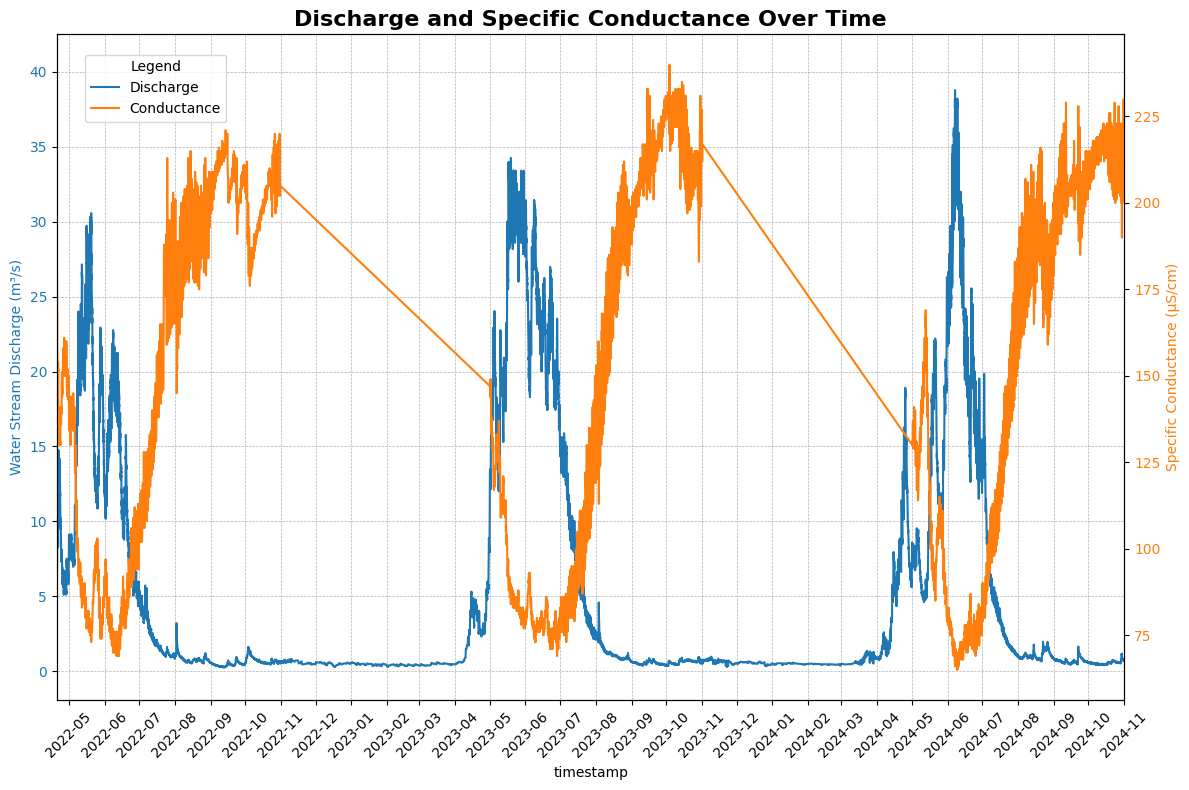

In [9]:
# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot discharge on the primary y-axis
sns.lineplot(
    data=discharge_df, 
    x='timestamp', 
    y='waterStreamDischarge', 
    ax=ax1, 
    color='#1f77b4',  # Soft blue
    label='Discharge',
    legend=False
)
ax1.set_ylabel("Water Stream Discharge (m³/s)", color='#1f77b4')
ax1.tick_params(axis='y', labelcolor='#1f77b4')

# Format the x-axis for dates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator())
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# Create a secondary y-axis
ax2 = ax1.twinx()
sns.lineplot(
    data=conductance_df, 
    x='timestamp', 
    y='waterSpecificConductance', 
    ax=ax2, 
    color='#ff7f0e',  # Soft orange
    label='Conductance',
    legend=False
)
ax2.set_ylabel("Specific Conductance (µS/cm)", color='#ff7f0e')
ax2.tick_params(axis='y', labelcolor='#ff7f0e')

# Automatically adjust x-axis limits to overlapping time range
common_start = max(discharge_df['timestamp'].min(), conductance_df['timestamp'].min())
common_end = min(discharge_df['timestamp'].max(), conductance_df['timestamp'].max())
ax1.set_xlim([common_start, common_end])

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines_1 + lines_2, 
    labels_1 + labels_2, 
    loc='upper left', 
    bbox_to_anchor=(0.02, 0.98), 
    title="Legend", 
    frameon=True
)

# Set the title and grid
plt.title("Discharge and Specific Conductance Over Time", fontsize=16, weight='bold')
ax1.grid(which='major', linestyle='--', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()